In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style
import os
from pathlib import Path

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## Part2 : Question 1

**Data loading and preprocessing**

In [20]:
import scipy.io as sio
from helpers import preprocess_subject

current_dir = os.getcwd()
data_root = Path(current_dir) / "Data"

subject_ids = range(1, 28)  # 1..27
subjects_preprocessed = {}

for sid in subject_ids:
    # Be robust to folder naming on different OS/file systems (e.g., Data/S2 vs Data/s2)
    candidate_dirs = [data_root / f"S{sid}", data_root / f"s{sid}"]
    fname = f"S{sid}_A1_E1.mat"

    mat_path = None
    for d in candidate_dirs:
        p = d / fname
        if p.exists():
            mat_path = p
            break

    if mat_path is None:
        raise FileNotFoundError(
            f"Could not find {fname} for subject {sid}. Tried: "
            + ", ".join(str(d / fname) for d in candidate_dirs)
        )

    data = sio.loadmat(mat_path)
    subjects_preprocessed[sid] = preprocess_subject(data)

print("Processed subjects:", list(subjects_preprocessed.keys()))


Processed subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


**Accessing the preprocessed data for each subject**

- subjects_preprocessed[sid]["emg_lp"] : 
Low-pass filtered EMG envelope, shape (T, C)
→ T time samples, C channels.
- subjects_preprocessed[sid]["restimulus"] : 
Relabelled movement labels over time, shape (T,)
→ 0 = rest, 1..S = movements.
- subjects_preprocessed[sid]["rerepetition"] : 
Repetition index over time, shape (T,)
→ 0 = no repetition, 1..R = repetition number.
- subjects_preprocessed[sid]["unique_stimuli"] : 
Sorted array of movement labels (without rest), shape (S,).
- subjects_preprocessed[sid]["unique_reps"] : 
Sorted array of repetition indices (without 0), shape (R,).
- subjects_preprocessed[sid]["trial_masks"] : 
List of boolean masks over time, one mask per trial.
Each mask selects all time samples belonging to a given (movement, repetition) pair.
- subjects_preprocessed[sid]["trial_labels"] : 
Movement label for each trial, shape (n_trials,).
- subjects_preprocessed[sid]["trial_reps"] : 
Repetition index for each trial, shape (n_trials,).
- subjects_preprocessed[sid]["channel_var"] : 
Variance of the filtered EMG for each channel over the whole recording, shape (C,).
This is used for basic channel-quality inspection.

In [21]:
from helpers import compute_trial_activation_scores, find_suspicious_trials

all_scores = []
suspicious = {}

for sid, res in subjects_preprocessed.items():
    qc = compute_trial_activation_scores(
        res["emg_lp"], res["trial_masks"], res["trial_labels"], res["trial_reps"]
    )
    for s, lab, rep in zip(qc["scores"], qc["labels"], qc["reps"]):
        all_scores.append((sid, lab, rep, s))

    idx_bad = find_suspicious_trials(qc["scores"], 0.1, -3.5)
    suspicious[sid] = {
        "indices": idx_bad,
        "labels": qc["labels"][idx_bad],
        "reps":   qc["reps"][idx_bad],
        "scores": qc["scores"][idx_bad],
    }

all_scores = np.array(all_scores, dtype=object)

for sid, info in suspicious.items():
    n_bad = len(info["indices"])
    print(f"Subject {sid:2d}: {n_bad:2d} suspicious trial(s)")

Subject  1:  0 suspicious trial(s)
Subject  2:  0 suspicious trial(s)
Subject  3:  0 suspicious trial(s)
Subject  4:  0 suspicious trial(s)
Subject  5:  0 suspicious trial(s)
Subject  6:  0 suspicious trial(s)
Subject  7:  0 suspicious trial(s)
Subject  8:  0 suspicious trial(s)
Subject  9:  0 suspicious trial(s)
Subject 10:  0 suspicious trial(s)
Subject 11:  0 suspicious trial(s)
Subject 12:  0 suspicious trial(s)
Subject 13:  0 suspicious trial(s)
Subject 14:  0 suspicious trial(s)
Subject 15:  0 suspicious trial(s)
Subject 16:  0 suspicious trial(s)
Subject 17:  0 suspicious trial(s)
Subject 18:  0 suspicious trial(s)
Subject 19:  0 suspicious trial(s)
Subject 20:  0 suspicious trial(s)
Subject 21:  0 suspicious trial(s)
Subject 22:  0 suspicious trial(s)
Subject 23:  2 suspicious trial(s)
Subject 24:  0 suspicious trial(s)
Subject 25:  1 suspicious trial(s)
Subject 26:  0 suspicious trial(s)
Subject 27:  0 suspicious trial(s)


**Visualizing the suspicious trials for the subjects 23 and 25**

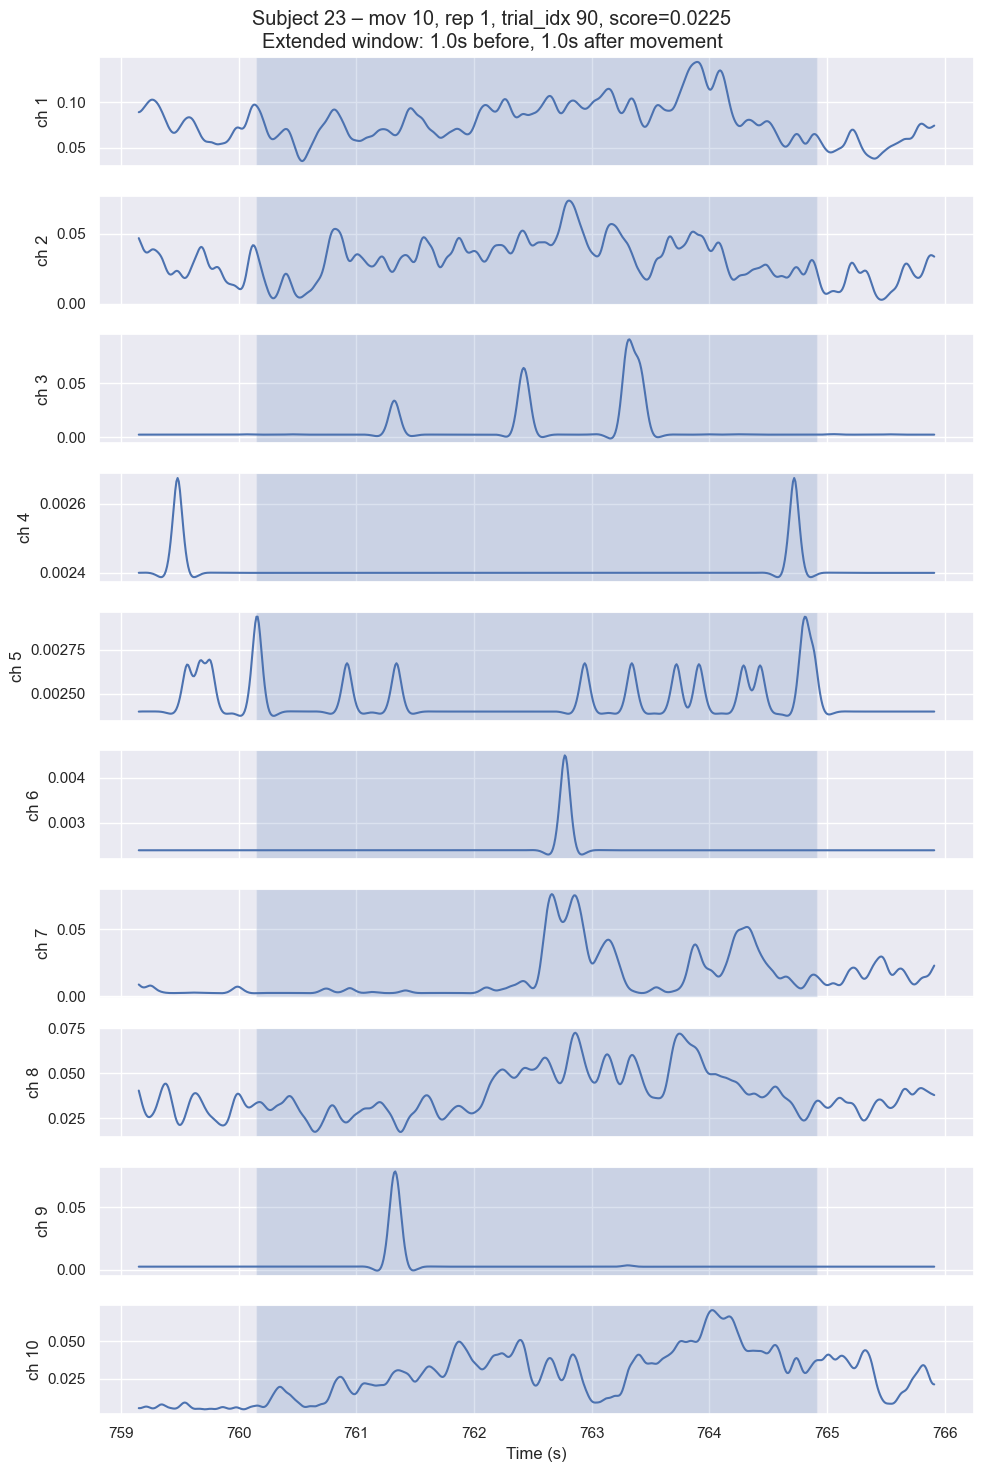

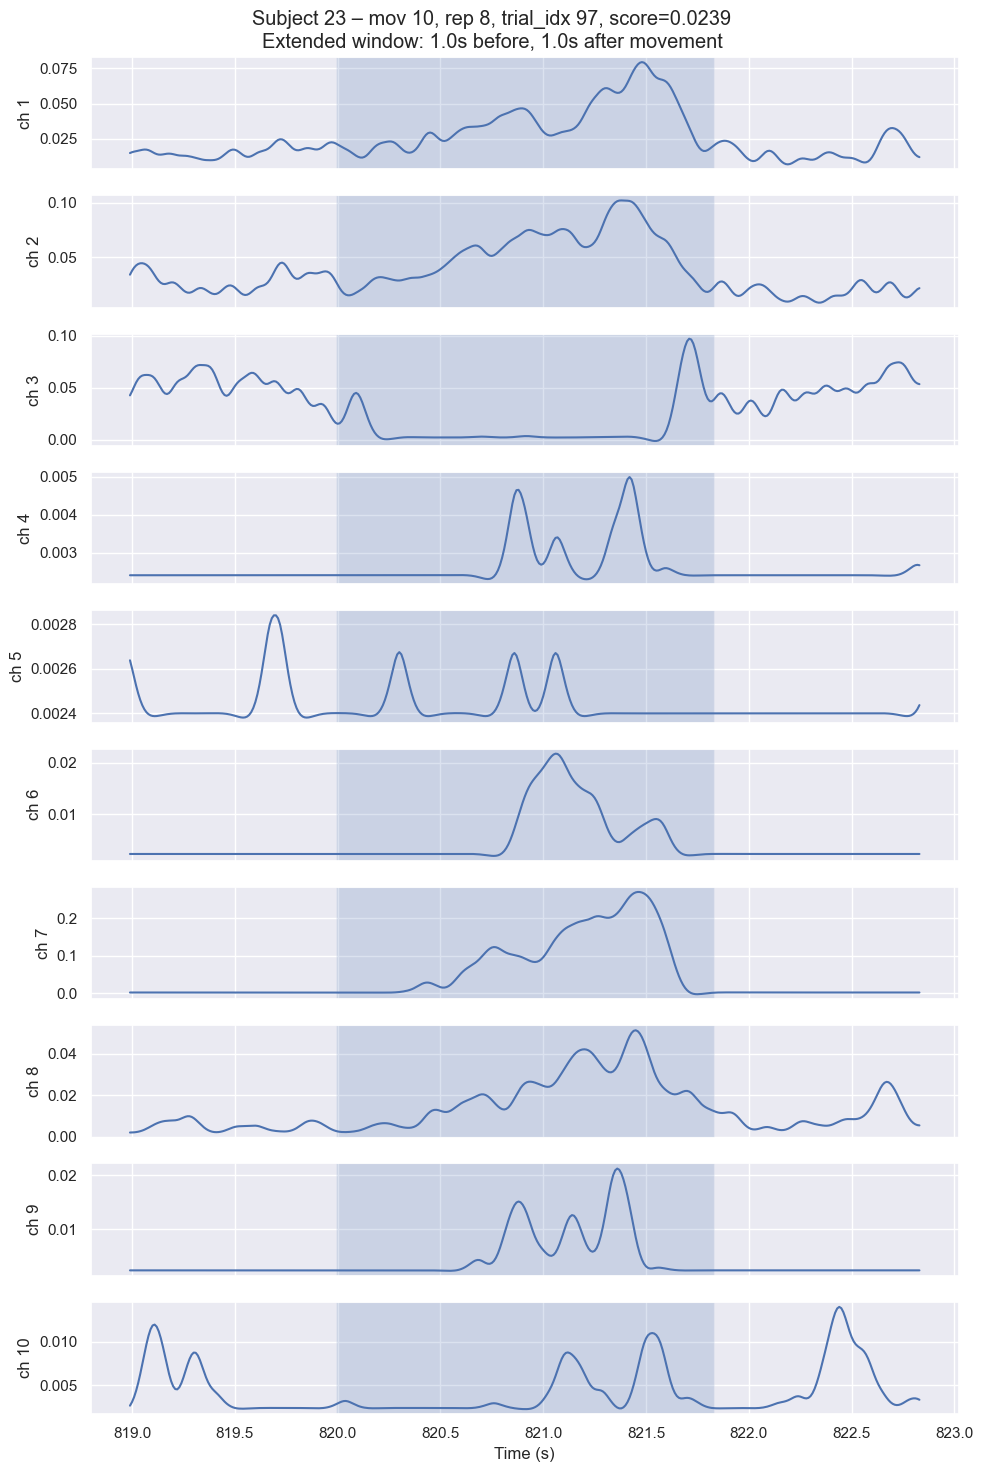

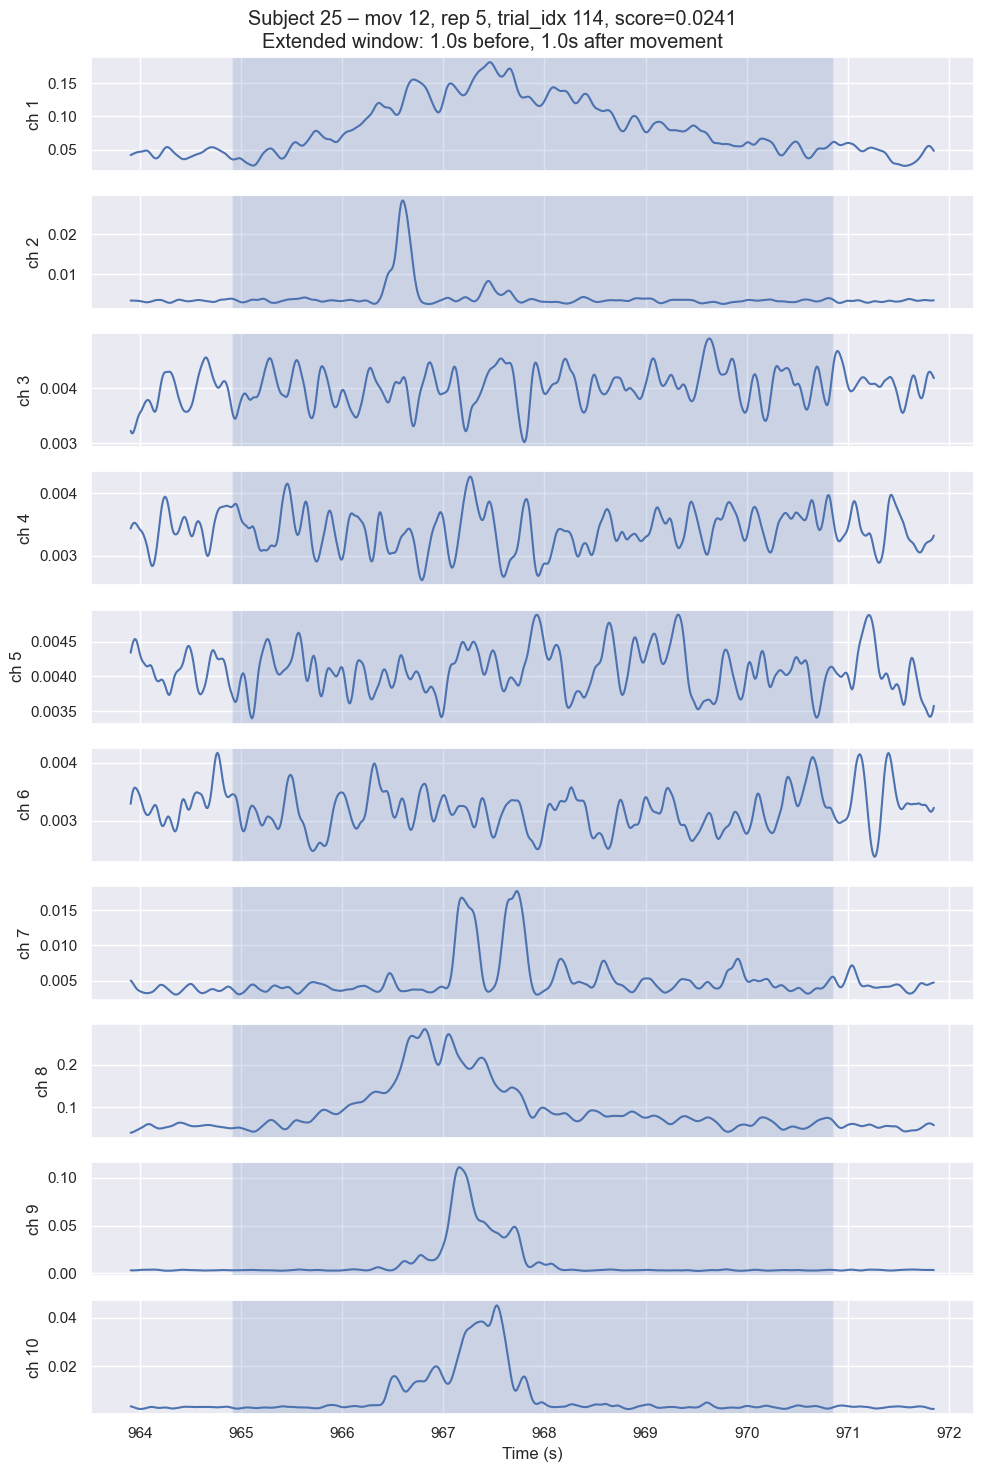

In [22]:
from helpers import plot_suspicious_trials_for_subject

plot_suspicious_trials_for_subject(23, suspicious, subjects_preprocessed)
plot_suspicious_trials_for_subject(25, suspicious, subjects_preprocessed)

In [23]:
sid = 25
res = subjects_preprocessed[sid]

channel_var = res["channel_var"]  # (n_channels,)

print(f"Subject {sid} – channel variances (whole recording):")
median_var = np.median(channel_var)
for ch, v in enumerate(channel_var, start=1):
    print(f"  ch {ch:2d}: var = {v:.4e}  ({v/median_var:5.2f} x median)")

Subject 25 – channel variances (whole recording):
  ch  1: var = 2.5451e-02  ( 0.48 x median)
  ch  2: var = 4.8254e-02  ( 0.91 x median)
  ch  3: var = 5.7804e-02  ( 1.09 x median)
  ch  4: var = 4.5026e-03  ( 0.08 x median)
  ch  5: var = 4.0393e-04  ( 0.01 x median)
  ch  6: var = 1.7168e-03  ( 0.03 x median)
  ch  7: var = 3.3714e-01  ( 6.36 x median)
  ch  8: var = 2.1481e-01  ( 4.05 x median)
  ch  9: var = 8.6150e-02  ( 1.62 x median)
  ch 10: var = 2.4966e-01  ( 4.71 x median)


For all 27 subjects (exercise 1), we applied the same preprocessing pipeline. The raw Ninapro EMG signals (already rectified and synchronized in the database) were low-pass filtered with a 2nd-order Butterworth filter at 5 Hz (zero-phase) to obtain a smooth EMG envelope. We then used the relabelled restimulus and rerepetition signals to segment the data into trials, where each trial corresponds to one movement and one repetition (movement s, repetition r). For each subject, we also computed the variance of the filtered EMG per channel and the set of unique movements and repetitions.

To assess channel quality, we inspected the channel-wise variance vector for each subject and identified channels with unusually low variance (e.g. channels 5–7 for subject 2, channels 4–6 for subject 25). However, when plotting the time courses of these channels with channel-specific scaling and aligning them with the movement labels, they still showed clear movement-related modulation (non-flat signals with bursts during active periods). We therefore interpreted them as low-amplitude but informative channels rather than dead electrodes, and we did not remove any channels from the analysis. Some channels (e.g. channels 3, 4, 6 and 9 for certain repetitions of movement 10 in subject 23) show a nearly flat baseline with a few sharp peaks during the movement window. This behaviour is consistent with low-level phasic activation or cross-talk from nearby muscles rather than dead electrodes: the channels are not constant over time and still show event-related modulation aligned with the movement label. Therefore we treat them as low-amplitude channels rather than corrupted channels.

To assess trial quality, we computed a simple activation score for each trial by averaging the low-pass filtered EMG over time and channels. Trials with extremely low scores relative to the subject’s distribution (e.g. <10% of the median activation or strong negative z-scores) were flagged as suspicious. Only a very small number of trials were flagged across all subjects, and visual inspection of these cases showed clear EMG bursts on several channels during the movement period, without any trial being completely flat or dominated by artefacts. As a result, we did not remove any trials from the multi-subject dataset.

Overall, after preprocessing and quality checks, the EMG data across all subjects appear reasonable and consistent with the expected muscle activations. All channels and trials are kept for the subsequent feature extraction and classification steps, while explicitly noting that some channels have lower variance and are likely less informative for certain movements.

## Part2 : Question 2.2

**Feature extraction across all subjects (exercise 1)**

We reuse the same feature set and helper-based pipeline as in Part 1 (MAV, STD, MAX, RMS, WL) and compute trial-wise feature matrices for each subject.

In [24]:

from helpers import (
    mav, std_feature, max_av, rms, waveform_length,
    build_dataset_from_ninapro_lp, get_feature_matrix_for_feature_index,
    split_trials_by_repetition
)

feature_fns = [mav, std_feature, max_av, rms, waveform_length]
feature_names = ["MAV", "STD", "MAX", "RMS", "WL"]

# Convenience
subject_ids = sorted(subjects_preprocessed.keys())
n_channels = subjects_preprocessed[subject_ids[0]]["emg_lp"].shape[1]

# Build trial-level datasets for every subject
subjects_trials = {}
for sid in subject_ids:
    res = subjects_preprocessed[sid]
    X_trials, y_trials, trial_reps = build_dataset_from_ninapro_lp(
        emg_lp=res["emg_lp"],
        stimulus=res["restimulus"],
        repetition=res["rerepetition"],
        features=feature_fns,
    )
    subjects_trials[sid] = {
        "X_trials": X_trials,
        "y_trials": y_trials,
        "trial_reps": trial_reps,
    }

print(f"Built trial datasets for {len(subjects_trials)} subjects.")
print("Example shapes (subject 1):", subjects_trials[1]["X_trials"].shape, subjects_trials[1]["y_trials"].shape)


Built trial datasets for 27 subjects.
Example shapes (subject 1): (120, 50) (120,)


**Across-subject overview of feature magnitudes**

For a compact across-subject view, we summarize each subject by the mean and standard deviation of each feature (aggregated over trials and channels), and visualize their distributions.

,subject,feature,mean,std
0,1,MAV,0.141644,0.222464
1,1,STD,0.100259,0.156149
2,1,MAX,0.368817,0.537199
3,1,RMS,0.175259,0.270453
4,1,WL,1.121614,1.424163


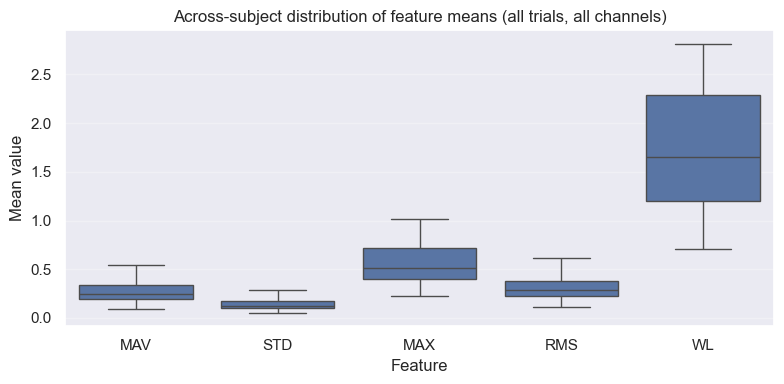

In [25]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

rows = []
for sid in subject_ids:
    X = subjects_trials[sid]["X_trials"]
    for f_idx, fname in enumerate(feature_names):
        feat = get_feature_matrix_for_feature_index(X, f_idx, n_channels)  # (n_trials, n_channels)
        rows.append({
            "subject": sid,
            "feature": fname,
            "mean": float(np.mean(feat)),
            "std": float(np.std(feat)),
        })

df_feat_summary = pd.DataFrame(rows)
display(df_feat_summary.head())

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_feat_summary, x="feature", y="mean")
plt.title("Across-subject distribution of feature means (all trials, all channels)")
plt.xlabel("Feature")
plt.ylabel("Mean value")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**Heatmap visualization**

We replicate the Part 1 heatmap: for one chosen movement, we display *channels × repetitions* for each feature. To avoid producing 27 figures, we illustrate on a small set of representative subjects.

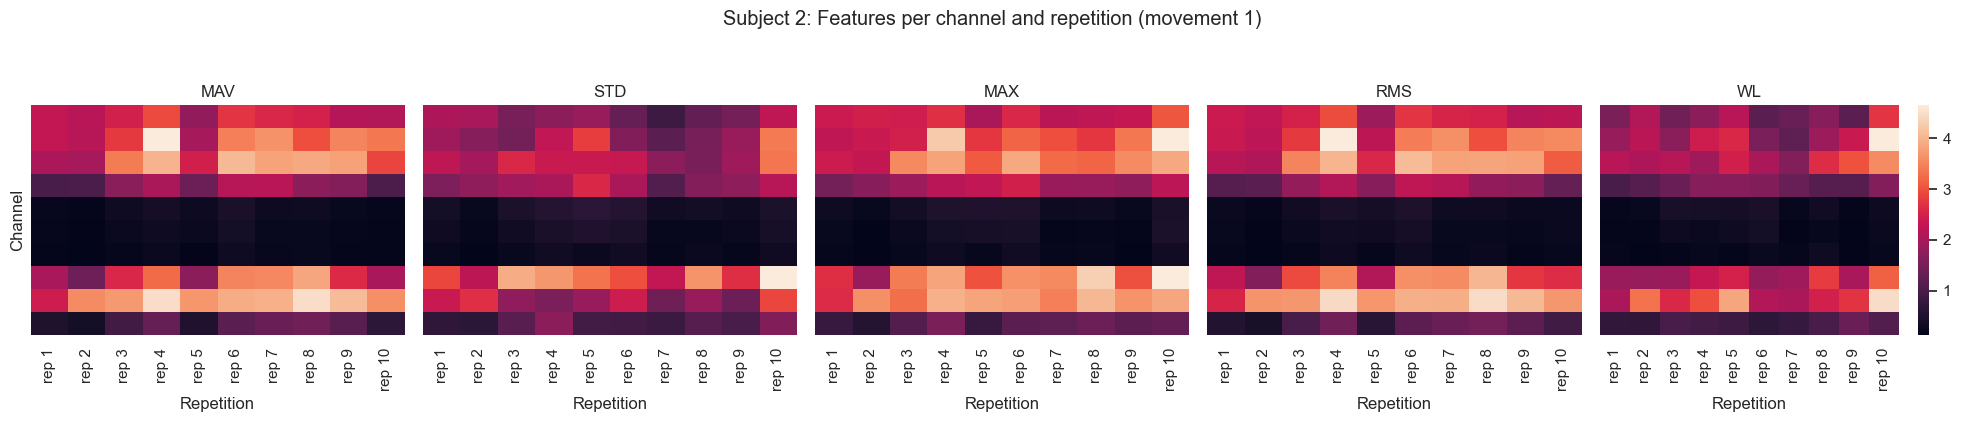

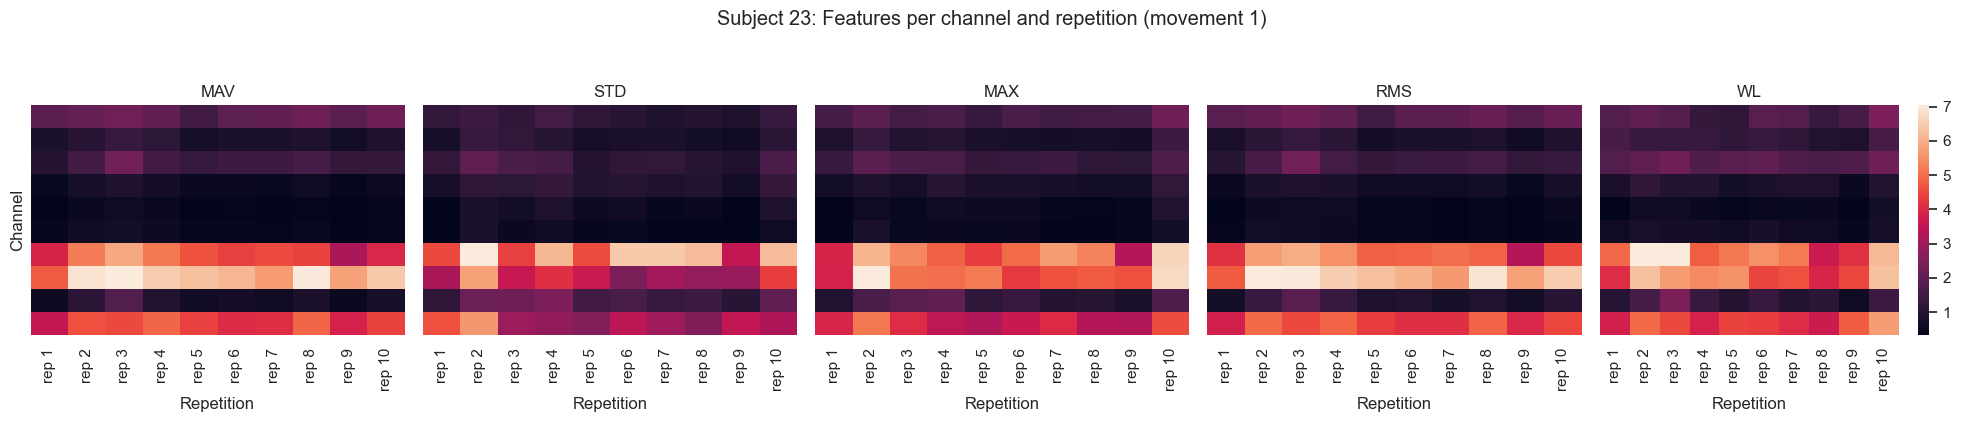

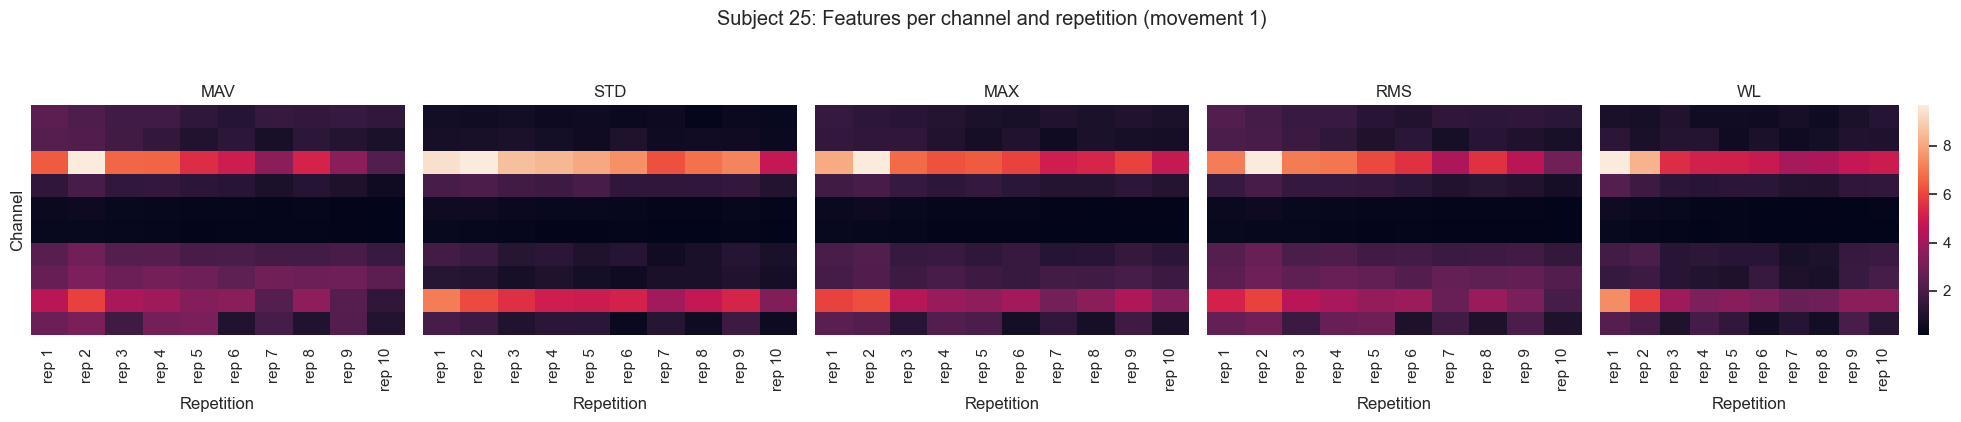

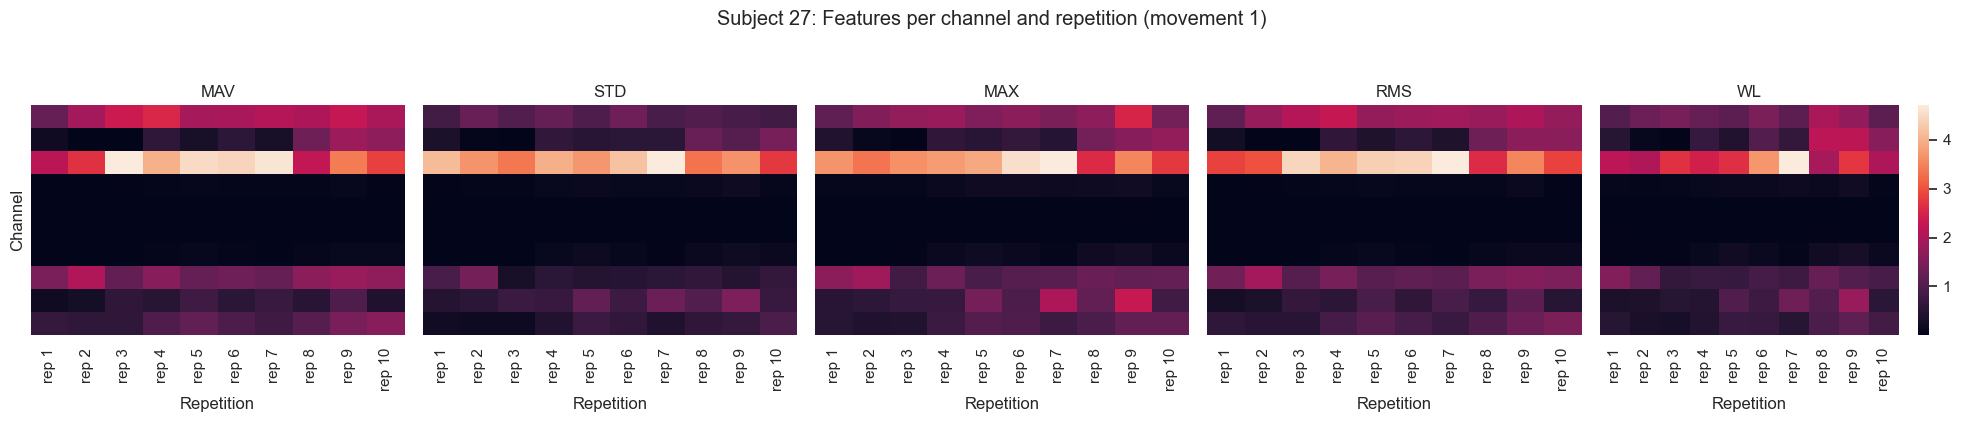

In [26]:

movement_to_plot = 1
subjects_to_plot = [2, 23, 25, 27]  # can be modified

for sid in subjects_to_plot:
    X_trials = subjects_trials[sid]["X_trials"]
    y_trials = subjects_trials[sid]["y_trials"]
    trial_reps = subjects_trials[sid]["trial_reps"]

    mask_movement = (y_trials == movement_to_plot)
    reps_movement = trial_reps[mask_movement]

    # Sort trials by repetition index for nicer plotting
    order = np.argsort(reps_movement)
    reps_sorted = reps_movement[order]

    n_features_total = len(feature_names)
    n_rows, n_cols = 1, n_features_total

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4), sharex=True, sharey=True)
    if n_features_total == 1:
        axes = [axes]

    for f_idx, fname in enumerate(feature_names):
        ax = axes[f_idx]

        feat_vals = get_feature_matrix_for_feature_index(X_trials, f_idx, n_channels)
        feat_movement = feat_vals[mask_movement, :]
        feat_movement = feat_movement[order, :]

        sns.heatmap(
            feat_movement.T,
            ax=ax,
            annot=False,
            xticklabels=[f"rep {r}" for r in reps_sorted],
            yticklabels=[f"ch {c+1}" for c in range(n_channels)] if f_idx == 0 else False,
            cbar=(f_idx == n_features_total - 1),
        )

        ax.set_title(fname)
        ax.set_xlabel("Repetition")
        ax.set_ylabel("Channel" if f_idx == 0 else "")

    plt.suptitle(f"Subject {sid}: Features per channel and repetition (movement {movement_to_plot})", y=1.05)
    plt.tight_layout()
    plt.show()


**Subject × channel heatmap (example on MAV)**

As an additional across-subject diagnostic, we compute the average MAV per channel for each subject and display a subjects × channels heatmap.

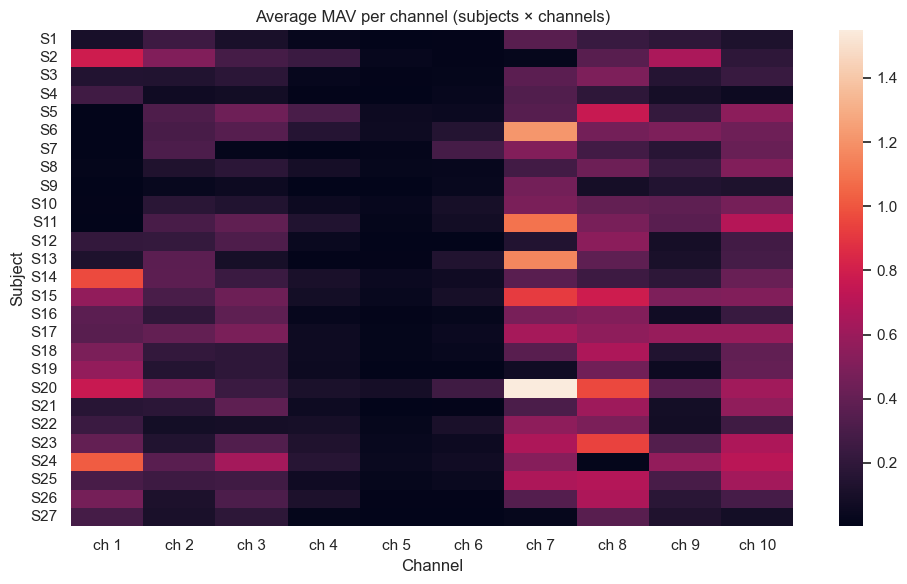

In [27]:

mav_means = []
for sid in subject_ids:
    X = subjects_trials[sid]["X_trials"]
    mav_vals = get_feature_matrix_for_feature_index(X, 0, n_channels)  # feature_index=0 => MAV
    mav_means.append(np.mean(mav_vals, axis=0))

mav_means = np.vstack(mav_means)  # (n_subjects, n_channels)

plt.figure(figsize=(10, 6))
sns.heatmap(
    mav_means,
    xticklabels=[f"ch {c+1}" for c in range(n_channels)],
    yticklabels=[f"S{sid}" for sid in subject_ids],
    cbar=True
)
plt.title("Average MAV per channel (subjects × channels)")
plt.xlabel("Channel")
plt.ylabel("Subject")
plt.tight_layout()
plt.show()


### Q2.2

We extracted the same feature set as in Part 1 (MAV, STD, MAX, RMS, WL) for every subject and compared feature values across subjects.

Two main trends appear:

* Strong inter-subject variability in absolute feature magnitude.
The boxplots of subject-averaged feature means show a wide spread, particularly for Waveform Length (WL) and other amplitude-sensitive features (MAV/RMS/MAX). This indicates that the global scale of the EMG activity varies substantially between subjects.

* Shared channel structure but different scaling across subjects.
The MAV heatmap (subjects × channels) shows that certain channels are consistently more active than others (suggesting common anatomical/muscle contributions), but the overall intensity differs strongly between subjects. This is consistent with typical EMG variability factors such as electrode placement, contact impedance, forearm morphology, and subject-specific contraction strategies.

Implication for classification:
Because these features are largely amplitude-based, they are highly informative within a subject (where electrode placement and scaling are stable), but they are not inherently subject-invariant, which anticipates a drop in performance when testing on unseen subjects.

## Part2 : Question 2.3

**Cross-subject generalization (train on 26 subjects, test on a held-out subject)**

We keep the exact repetition-based train/validation split used in Part 1, but apply it on the *training subjects only*. The held-out subject is never seen during training or hyperparameter selection.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import time

# Part 2 – Q2.3 (as written in the brief):
# Train on 26 subjects (aggregate ALL trials from those subjects) and test on a held-out subject.
# We keep the Part 1 Random Forest family + param grid, but tune hyperparameters using
# subject-aware CV (GroupKFold) to avoid "mixing" the same subject across folds.

test_sid = 27  # held-out subject (can be changed)

# --- Aggregate training subjects (ALL repetitions) ---
X_train_list, y_train_list, g_train_list = [], [], []
for sid in subject_ids:
    if sid == test_sid:
        continue
    X = subjects_trials[sid]["X_trials"]
    y = subjects_trials[sid]["y_trials"]
    X_train_list.append(X)
    y_train_list.append(y)
    g_train_list.append(np.full(len(y), sid, dtype=int))

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
groups  = np.concatenate(g_train_list)

# --- Held-out test subject (ALL repetitions) ---
X_test = subjects_trials[test_sid]["X_trials"]
y_test = subjects_trials[test_sid]["y_trials"]

# --- Scaling (kept for consistency with Part 1, even though RF does not strictly require it) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Same Random Forest hyperparameter grid as Part 1 ---
algorithm_name = "Random Forest (cross-subject)"
base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100, 400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"Starting hyperparameter optimization for {algorithm_name} (subject-aware CV)")

cv = GroupKFold(n_splits=5)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train, groups=groups)
end_time = time.time()

print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy (GroupKFold): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# --- Held-out subject performance ---
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Held-out subject (S{test_sid}) accuracy (ALL trials): {test_accuracy:.4f}")

Starting hyperparameter optimization for Random Forest (cross-subject) (subject-aware CV)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Optimization completed in 140.77 seconds

Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation accuracy (GroupKFold): 0.3250
Held-out subject (S27) accuracy (ALL trials): 0.2667


### Compute multiple evaluation metrics

We compute the same metrics and plots as in Part 1 (accuracy, balanced accuracy, macro precision/recall/F1, confusion matrix, and per-class accuracy).

In [29]:

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Multiple metrics (same as Part 1)
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
precision_macro = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")


Test Accuracy: 0.2667
Balanced Accuracy: 0.2667
Macro Precision: 0.1635
Macro Recall: 0.2667
Macro F1-score: 0.1949


### Confusion Matrix Visualization

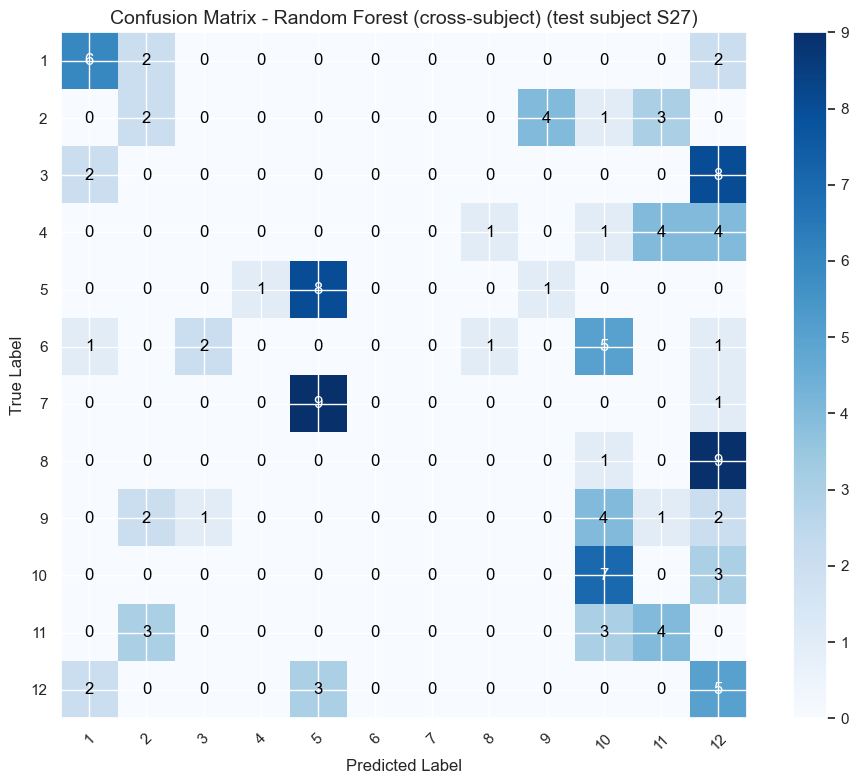

In [30]:

cm = confusion_matrix(y_test, y_test_pred)

unique_labels = np.unique(y_test)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {algorithm_name} (test subject S{test_sid})', fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


### Per-class performance analysis

In [31]:
print("PER-CLASS CLASSIFICATION REPORT")
print("\n", classification_report(y_test, y_test_pred, target_names=[f"Movement {i}" for i in unique_labels]))

PER-CLASS CLASSIFICATION REPORT

               precision    recall  f1-score   support

  Movement 1       0.55      0.60      0.57        10
  Movement 2       0.22      0.20      0.21        10
  Movement 3       0.00      0.00      0.00        10
  Movement 4       0.00      0.00      0.00        10
  Movement 5       0.40      0.80      0.53        10
  Movement 6       0.00      0.00      0.00        10
  Movement 7       0.00      0.00      0.00        10
  Movement 8       0.00      0.00      0.00        10
  Movement 9       0.00      0.00      0.00        10
 Movement 10       0.32      0.70      0.44        10
 Movement 11       0.33      0.40      0.36        10
 Movement 12       0.14      0.50      0.22        10

    accuracy                           0.27       120
   macro avg       0.16      0.27      0.19       120
weighted avg       0.16      0.27      0.19       120



c:\Users\ocram\anaconda3\envs\episcalp\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ocram\anaconda3\envs\episcalp\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ocram\anaconda3\envs\episcalp\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

### Analyze per-class accuracy

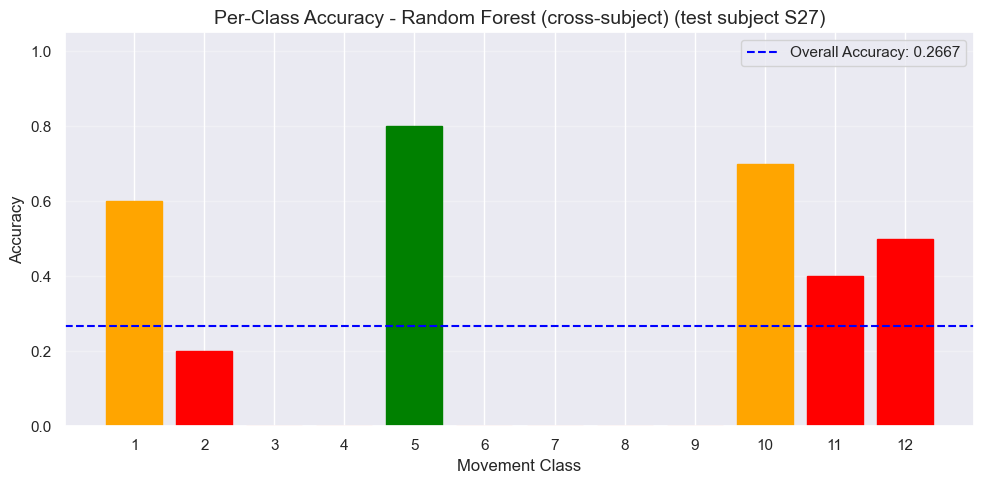

In [32]:

per_class_accuracy = []
for label in unique_labels:
    mask = (y_test == label)
    if np.sum(mask) == 0:
        per_class_accuracy.append(np.nan)
    else:
        per_class_accuracy.append(np.mean(y_test_pred[mask] == label))

plt.figure(figsize=(10, 5))
bars = plt.bar(unique_labels, per_class_accuracy)

for bar, acc in zip(bars, per_class_accuracy):
    if np.isnan(acc):
        continue
    if acc >= 0.8:
        bar.set_color('green')
    elif acc >= 0.6:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.axhline(y=accuracy, color='blue', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
plt.xlabel('Movement Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f'Per-Class Accuracy - {algorithm_name} (test subject S{test_sid})', fontsize=14)
plt.xticks(unique_labels)
plt.ylim([0, 1.05])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Within-subject baseline (for comparison)**

To compare with cross-subject generalization, we compute a within-subject baseline on the held-out subject using the same repetition split as in Part 1.

In [33]:
# Within-subject split on the held-out subject (same repetition split as Part 1)

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

TRAIN_REPS = np.array([1, 3, 4, 6, 7, 9])
VAL_REPS   = np.array([8])
TEST_REPS  = np.array([2, 5, 10])

X_s = subjects_trials[test_sid]["X_trials"]
y_s = subjects_trials[test_sid]["y_trials"]
reps_s = subjects_trials[test_sid]["trial_reps"]

train_mask_s, val_mask_s, test_mask_s = split_trials_by_repetition(reps_s, TRAIN_REPS, VAL_REPS, TEST_REPS)

X_train_s, y_train_s = X_s[train_mask_s], y_s[train_mask_s]
X_val_s, y_val_s     = X_s[val_mask_s],   y_s[val_mask_s]
X_test_s, y_test_s   = X_s[test_mask_s],  y_s[test_mask_s]

scaler_s = StandardScaler()
X_train_s_scaled = scaler_s.fit_transform(X_train_s)
X_val_s_scaled   = scaler_s.transform(X_val_s)
X_test_s_scaled  = scaler_s.transform(X_test_s)

print("Within-subject sets (held-out subject):")
print("  Train:", X_train_s.shape, "Val:", X_val_s.shape, "Test:", X_test_s.shape)

# Reuse the same hyperparameter grid (Part 1 grid) for a fair baseline
grid_search_s = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_search_s.fit(X_train_s_scaled, y_train_s)

best_model_s = grid_search_s.best_estimator_
y_test_s_pred = best_model_s.predict(X_test_s_scaled)

within_acc = accuracy_score(y_test_s, y_test_s_pred)
print(f"Within-subject (S{test_sid}) test accuracy (test reps only): {within_acc:.4f}")
print("Best within-subject params:", grid_search_s.best_params_)

Within-subject sets (held-out subject):
  Train: (72, 50) Val: (12, 50) Test: (36, 50)
Within-subject (S27) test accuracy (test reps only): 0.8611
Best within-subject params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### Q2.3

We trained a Random Forest classifier on the aggregated dataset of 26 subjects and evaluated on a held-out subject (subject 27). Cross-subject results were:

* Accuracy ≈ 0.27

* Balanced accuracy ≈ 0.27

* Macro-F1 ≈ 0.19

With 12 classes, chance accuracy is about 0.083, so the model performs above chance, but generalization remains limited.

To contextualize this result, we also computed a within-subject baseline on subject 27 using the same repetition-based train/val/test split as Part 1. This within-subject evaluation achieved:

* Test accuracy ≈ 0.86

This large gap demonstrates that the model is very effective when the training and test distributions come from the same subject, but struggles when the test subject is new.

The confusion matrix and per-class report for the cross-subject case show that the model predicts only a subset of movements reliably (e.g., some classes with moderate-to-high recall), while several movements have near-zero recall. This suggests that for many movements, the feature distributions of subject 27 overlap strongly with other movements when compared to the population training distribution—an expected outcome given the feature variability observed in Part 2.2.


## Part2 : Question 2.4

**Leave-One-Subject-Out (LOSO) evaluation**

To keep the workflow close to Part 1 while keeping runtime reasonable, we fix the Random Forest hyperparameters to those obtained in Part2.3 (cross-subject tuning) and evaluate LOSO across all 27 subjects.

In [34]:

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

best_params_cross_subject = grid_search.best_params_
print("Using fixed hyperparameters for LOSO:", best_params_cross_subject)

cv_rows = []
for sid_test in subject_ids:
    X_train_list, y_train_list = [], []

    for sid in subject_ids:
        if sid == sid_test:
            continue

        X = subjects_trials[sid]["X_trials"]
        y = subjects_trials[sid]["y_trials"]
        reps = subjects_trials[sid]["trial_reps"]

        train_mask, _, _ = split_trials_by_repetition(reps, TRAIN_REPS, VAL_REPS, TEST_REPS)
        X_train_list.append(X[train_mask])
        y_train_list.append(y[train_mask])

    X_train_fold = np.vstack(X_train_list)
    y_train_fold = np.concatenate(y_train_list)

    X_test_fold = subjects_trials[sid_test]["X_trials"]
    y_test_fold = subjects_trials[sid_test]["y_trials"]

    scaler_fold = StandardScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_test_fold_scaled  = scaler_fold.transform(X_test_fold)

    model_fold = RandomForestClassifier(random_state=42, **best_params_cross_subject)
    model_fold.fit(X_train_fold_scaled, y_train_fold)

    y_pred_fold = model_fold.predict(X_test_fold_scaled)

    cv_rows.append({
        "test_subject": sid_test,
        "accuracy": accuracy_score(y_test_fold, y_pred_fold),
        "balanced_accuracy": balanced_accuracy_score(y_test_fold, y_pred_fold),
        "macro_f1": f1_score(y_test_fold, y_pred_fold, average="macro", zero_division=0)
    })

df_loso = pd.DataFrame(cv_rows).sort_values("test_subject")
display(df_loso.head())

print("\nLOSO summary:")
print(df_loso[["accuracy", "balanced_accuracy", "macro_f1"]].agg(["mean", "std"]))


Using fixed hyperparameters for LOSO: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


,test_subject,accuracy,balanced_accuracy,macro_f1
0,1,0.291667,0.291667,0.220098
1,2,0.175000,0.175000,0.107069
2,3,0.450000,0.450000,0.378634
3,4,0.325000,0.325000,0.228680
4,5,0.441667,0.441667,0.354342



LOSO summary:
      accuracy  balanced_accuracy  macro_f1
mean  0.329012           0.329012  0.272479
std   0.118628           0.118628  0.120083


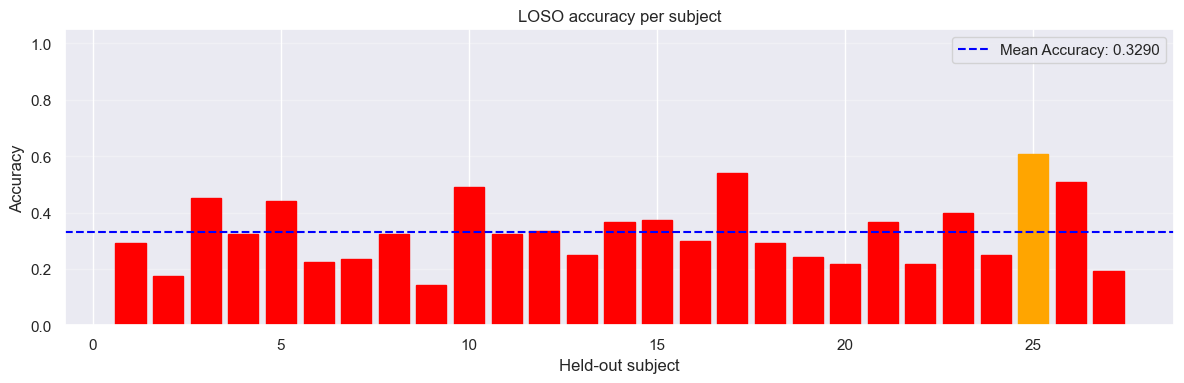

In [37]:

# Visualization in the same spirit as Part 1 bar analyses
plt.figure(figsize=(12, 4))
bars = plt.bar(df_loso["test_subject"], df_loso["accuracy"])

for bar, acc in zip(bars, df_loso["accuracy"]):
    if acc >= 0.8:
        bar.set_color('green')
    elif acc >= 0.6:
        bar.set_color('orange')
    else:
        bar.set_color('red')

mean_acc = df_loso["accuracy"].mean()
plt.axhline(y=mean_acc, color='blue', linestyle='--', label=f'Mean Accuracy: {mean_acc:.4f}')
plt.xlabel("Held-out subject")
plt.ylabel("Accuracy")
plt.title("LOSO accuracy per subject")
plt.ylim([0, 1.05])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Q2.4

We then evaluated subject-independent performance more systematically using LOSO cross-validation: each fold trains on 26 subjects and tests on the remaining subject.

The results show:

* Mean accuracy ≈ 0.33

* Std accuracy ≈ 0.12

* Mean macro-F1 ≈ 0.27

* Std macro-F1 ≈ 0.12

These values confirm two key points:

* Cross-subject generalization is moderate on average (well above chance but far below within-subject performance).

* Performance varies strongly across subjects, indicating that certain individuals are substantially harder to decode than others. This variability is consistent with differences in signal quality, electrode placement, physiological characteristics, and contraction consistency across subjects.

## Part2 : Question 2.5

**Effect of the number of training subjects (fixed test subject)**

We fix the test subject to S27 and train on an increasing number of subjects (S1, then S1–S2, …, S1–S26). Hyperparameters are fixed to the values tuned in Part2.3 to isolate the effect of training-set size.

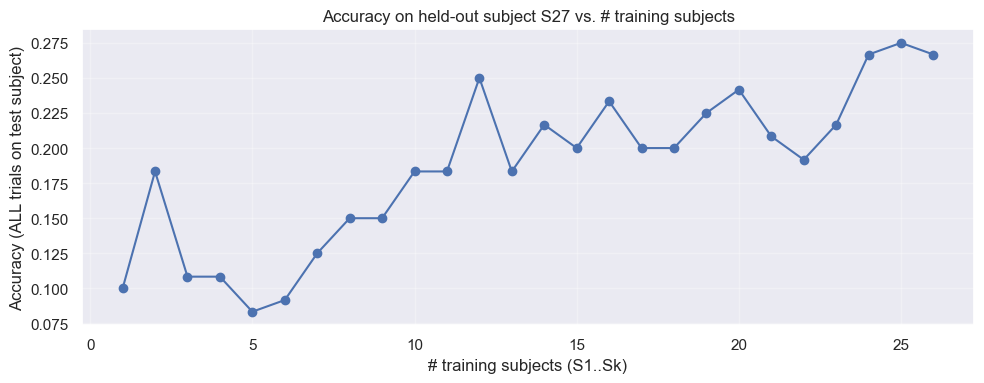

In [36]:
# Part 2 – Q2.5: Effect of the number of training subjects (no CV, as requested in the brief)
# Example in the brief: keep subject 27 as test subject; train on subject 1, then 1&2, ..., up to 26.

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

test_sid_fixed = 27
train_subjects_ordered = [sid for sid in subject_ids if sid != test_sid_fixed]  # 1..26

X_test_k = subjects_trials[test_sid_fixed]["X_trials"]
y_test_k = subjects_trials[test_sid_fixed]["y_trials"]

accs = []
for k in range(1, len(train_subjects_ordered) + 1):
    selected = train_subjects_ordered[:k]

    # Aggregate ALL trials from the selected training subjects
    X_train_k = np.vstack([subjects_trials[sid]["X_trials"] for sid in selected])
    y_train_k = np.concatenate([subjects_trials[sid]["y_trials"] for sid in selected])

    scaler_k = StandardScaler()
    X_train_k_scaled = scaler_k.fit_transform(X_train_k)
    X_test_k_scaled  = scaler_k.transform(X_test_k)

    model_k = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params_cross_subject)
    model_k.fit(X_train_k_scaled, y_train_k)

    y_pred_k = model_k.predict(X_test_k_scaled)
    acc_k = accuracy_score(y_test_k, y_pred_k)
    accs.append(acc_k)

plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_subjects_ordered) + 1), accs, marker='o')
plt.title(f"Accuracy on held-out subject S{test_sid_fixed} vs. # training subjects")
plt.xlabel("# training subjects (S1..Sk)")
plt.ylabel("Accuracy (ALL trials on test subject)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Q2.5

Finally, we fixed the test subject (subject 27) and increased the number of training subjects incrementally (S1 only, S1–S2, …, up to 26 subjects).

The learning curve exhibits:

* Clear improvement when moving from very few training subjects to a moderate number.

* A plateau (and occasional fluctuations) around 0.25–0.28 accuracy, even as more subjects are added.

This behavior indicates diminishing returns: once the model has seen enough subjects to learn general tendencies, adding more subjects mainly contributes additional inter-subject variability (different scaling/channel patterns) rather than purely improving discriminative structure for the target subject.

Practical implication:
If data collection is expensive, these results suggest that a purely population-trained classifier may have limited performance for new users unless we incorporate either:

* more subject-invariant features / normalization strategies, or

* a small subject-specific calibration phase.
